# Experiment B: Adaptive Learning Rate as a Dynamic Parameter

## Overview

This notebook explores treating learning rate as a **dynamic parameter** that adapts during training, rather than a fixed hyperparameter. We implement an adaptive learning rate strategy that monitors loss spikes and automatically adjusts the learning rate.

## Research Question

Can learning rate be treated as a dynamic parameter instead of a fixed hyperparameter to improve convergence speed and stability?

## Methodology

1. **Start with high learning rate**: Begin training with a relatively high learning rate
2. **Monitor loss spikes**: Track MSE/RMSE for sudden increases
3. **Adaptive reduction**: When a spike is detected, reduce learning rate by:
   - Dividing by 2 (multiplicative decay)
   - Or applying square root (slower decay)
4. **Compare strategies**: Fixed LR, step decay, adaptive LR

## Hypothesis

Adaptive learning rates can improve training stability by automatically responding to optimization difficulties, potentially achieving better convergence than fixed or manually scheduled learning rates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

## Load Data

In [2]:
# Load data
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape[0]} samples")

Training set: 16512 samples


## Adaptive Learning Rate Implementation

In [3]:
class LinearRegressionAdaptiveLR:
    """Linear Regression with adaptive learning rate."""
    
    def __init__(self, initial_lr=0.1, n_iterations=1000, batch_size=32, 
                 spike_threshold=1.1, decay_method='divide', random_state=42):
        self.initial_lr = initial_lr
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.spike_threshold = spike_threshold  # Loss increase threshold
        self.decay_method = decay_method  # 'divide' or 'sqrt'
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.lr_history = []
        
    def _initialize_parameters(self, n_features):
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
    def _compute_loss(self, X, y):
        predictions = X @ self.weights + self.bias
        return np.mean((y - predictions) ** 2)
    
    def _compute_gradients(self, X_batch, y_batch):
        n_samples = X_batch.shape[0]
        predictions = X_batch @ self.weights + self.bias
        error = predictions - y_batch
        dw = (2 / n_samples) * (X_batch.T @ error)
        db = (2 / n_samples) * np.sum(error)
        return dw, db
    
    def _adjust_learning_rate(self, current_lr, previous_loss, current_loss):
        """Adjust learning rate based on loss spike detection."""
        if previous_loss is None:
            return current_lr
        
        # Detect spike: loss increased by more than threshold
        loss_ratio = current_loss / previous_loss if previous_loss > 0 else 1.0
        
        if loss_ratio > self.spike_threshold:
            # Reduce learning rate
            if self.decay_method == 'divide':
                new_lr = current_lr / 2.0
            elif self.decay_method == 'sqrt':
                new_lr = current_lr * np.sqrt(0.5)
            else:
                new_lr = current_lr
            
            # Minimum learning rate threshold
            new_lr = max(new_lr, 1e-6)
            return new_lr
        
        return current_lr
    
    def fit(self, X, y, verbose=True):
        """Train with adaptive learning rate."""
        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)
        
        current_lr = self.initial_lr
        previous_loss = None
        
        for iteration in range(self.n_iterations):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            # Mini-batch gradient descent
            epoch_losses = []
            for i in range(0, n_samples, self.batch_size):
                end_idx = min(i + self.batch_size, n_samples)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]
                
                # Compute gradients
                dw, db = self._compute_gradients(X_batch, y_batch)
                
                # Update parameters
                self.weights -= current_lr * dw
                self.bias -= current_lr * db
                
                batch_loss = self._compute_loss(X_batch, y_batch)
                epoch_losses.append(batch_loss)
            
            # Average loss for epoch
            avg_loss = np.mean(epoch_losses)
            
            # Adjust learning rate based on loss spike
            current_lr = self._adjust_learning_rate(current_lr, previous_loss, avg_loss)
            previous_loss = avg_loss
            
            # Store history
            self.loss_history.append(avg_loss)
            self.lr_history.append(current_lr)
            
            if verbose and (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")
    
    def predict(self, X):
        return X @ self.weights + self.bias

print("LinearRegressionAdaptiveLR defined!")

LinearRegressionAdaptiveLR defined!


## Baseline: Fixed Learning Rate

In [4]:
class LinearRegressionFixedLR:
    """Baseline: Fixed learning rate."""
    
    def __init__(self, learning_rate=0.01, n_iterations=1000, batch_size=32, random_state=42):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _initialize_parameters(self, n_features):
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
    def _compute_loss(self, X, y):
        predictions = X @ self.weights + self.bias
        return np.mean((y - predictions) ** 2)
    
    def _compute_gradients(self, X_batch, y_batch):
        n_samples = X_batch.shape[0]
        predictions = X_batch @ self.weights + self.bias
        error = predictions - y_batch
        dw = (2 / n_samples) * (X_batch.T @ error)
        db = (2 / n_samples) * np.sum(error)
        return dw, db
    
    def fit(self, X, y, verbose=True):
        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)
        
        for iteration in range(self.n_iterations):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_losses = []
            for i in range(0, n_samples, self.batch_size):
                end_idx = min(i + self.batch_size, n_samples)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]
                
                dw, db = self._compute_gradients(X_batch, y_batch)
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
                batch_loss = self._compute_loss(X_batch, y_batch)
                epoch_losses.append(batch_loss)
            
            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)
            
            if verbose and (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, Loss: {avg_loss:.4f}")
    
    def predict(self, X):
        return X @ self.weights + self.bias

# Train fixed LR baseline
print("Training fixed LR baseline...")
model_fixed = LinearRegressionFixedLR(learning_rate=0.01, n_iterations=1000, random_state=42)
model_fixed.fit(X_train_scaled, y_train, verbose=True)

y_pred_fixed = model_fixed.predict(X_test_scaled)
test_rmse_fixed = np.sqrt(mean_squared_error(y_test, y_pred_fixed))
print(f"\nFixed LR Test RMSE: {test_rmse_fixed:.4f}")

Training fixed LR baseline...
Iteration 100/1000, Loss: 0.8959
Iteration 200/1000, Loss: 0.5720
Iteration 300/1000, Loss: 0.6929
Iteration 400/1000, Loss: 0.5941
Iteration 500/1000, Loss: 0.5213
Iteration 600/1000, Loss: 7.7508
Iteration 700/1000, Loss: 0.5185
Iteration 800/1000, Loss: 0.5490
Iteration 900/1000, Loss: 0.5208
Iteration 1000/1000, Loss: 0.5553

Fixed LR Test RMSE: 0.7608


## Step Decay Learning Rate (Comparison Baseline)

In [5]:
class LinearRegressionStepDecay:
    """Step decay learning rate schedule."""
    
    def __init__(self, initial_lr=0.1, decay_rate=0.5, decay_steps=250, 
                 n_iterations=1000, batch_size=32, random_state=42):
        self.initial_lr = initial_lr
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.lr_history = []
        
    def _initialize_parameters(self, n_features):
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
    def _compute_loss(self, X, y):
        predictions = X @ self.weights + self.bias
        return np.mean((y - predictions) ** 2)
    
    def _compute_gradients(self, X_batch, y_batch):
        n_samples = X_batch.shape[0]
        predictions = X_batch @ self.weights + self.bias
        error = predictions - y_batch
        dw = (2 / n_samples) * (X_batch.T @ error)
        db = (2 / n_samples) * np.sum(error)
        return dw, db
    
    def _get_learning_rate(self, iteration):
        """Step decay: reduce LR every decay_steps."""
        step = iteration // self.decay_steps
        return self.initial_lr * (self.decay_rate ** step)
    
    def fit(self, X, y, verbose=True):
        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)
        
        for iteration in range(self.n_iterations):
            current_lr = self._get_learning_rate(iteration)
            
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_losses = []
            for i in range(0, n_samples, self.batch_size):
                end_idx = min(i + self.batch_size, n_samples)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]
                
                dw, db = self._compute_gradients(X_batch, y_batch)
                self.weights -= current_lr * dw
                self.bias -= current_lr * db
                
                batch_loss = self._compute_loss(X_batch, y_batch)
                epoch_losses.append(batch_loss)
            
            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)
            self.lr_history.append(current_lr)
            
            if verbose and (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")
    
    def predict(self, X):
        return X @ self.weights + self.bias

# Train step decay
print("Training step decay model...")
model_step = LinearRegressionStepDecay(initial_lr=0.01, decay_steps=250, n_iterations=1000, random_state=42)
model_step.fit(X_train_scaled, y_train, verbose=True)

y_pred_step = model_step.predict(X_test_scaled)
test_rmse_step = np.sqrt(mean_squared_error(y_test, y_pred_step))
print(f"\nStep Decay Test RMSE: {test_rmse_step:.4f}")

Training step decay model...
Iteration 100/1000, Loss: 0.8959, LR: 0.010000
Iteration 200/1000, Loss: 0.5720, LR: 0.010000
Iteration 300/1000, Loss: 0.5434, LR: 0.005000
Iteration 400/1000, Loss: 0.5185, LR: 0.005000
Iteration 500/1000, Loss: 0.5158, LR: 0.005000
Iteration 600/1000, Loss: 0.5163, LR: 0.002500
Iteration 700/1000, Loss: 0.5158, LR: 0.002500
Iteration 800/1000, Loss: 0.5166, LR: 0.001250
Iteration 900/1000, Loss: 0.5170, LR: 0.001250
Iteration 1000/1000, Loss: 0.5170, LR: 0.001250

Step Decay Test RMSE: 0.7462


## Adaptive Learning Rate Training

In [6]:
# Train adaptive LR model
print("Training adaptive LR model...")
model_adaptive = LinearRegressionAdaptiveLR(
    initial_lr=0.1,
    n_iterations=1000,
    spike_threshold=1.1,
    decay_method='divide',
    random_state=42
)
model_adaptive.fit(X_train_scaled, y_train, verbose=True)

y_pred_adaptive = model_adaptive.predict(X_test_scaled)
test_rmse_adaptive = np.sqrt(mean_squared_error(y_test, y_pred_adaptive))
print(f"\nAdaptive LR Test RMSE: {test_rmse_adaptive:.4f}")

Training adaptive LR model...
Iteration 100/1000, Loss: 0.5163, LR: 0.003125
Iteration 200/1000, Loss: 0.5158, LR: 0.003125
Iteration 300/1000, Loss: 0.5184, LR: 0.003125
Iteration 400/1000, Loss: 0.5161, LR: 0.003125
Iteration 500/1000, Loss: 0.5155, LR: 0.003125
Iteration 600/1000, Loss: 0.5164, LR: 0.003125
Iteration 700/1000, Loss: 0.5154, LR: 0.003125
Iteration 800/1000, Loss: 0.5171, LR: 0.003125
Iteration 900/1000, Loss: 0.5157, LR: 0.003125
Iteration 1000/1000, Loss: 0.5158, LR: 0.003125

Adaptive LR Test RMSE: 0.7466


In [7]:
# Save results using pickle
import pickle
import os

results_dir = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(results_dir, exist_ok=True)

adaptive_results = {
    'fixed_lr': {
        'method': 'Fixed LR',
        'test_rmse': test_rmse_fixed,
        'loss_history': model_fixed.loss_history.copy(),
        'learning_rate': 0.01
    },
    'step_decay': {
        'method': 'Step Decay',
        'test_rmse': test_rmse_step,
        'loss_history': model_step.loss_history.copy(),
        'lr_history': model_step.lr_history.copy()
    },
    'adaptive_lr': {
        'method': 'Adaptive LR',
        'test_rmse': test_rmse_adaptive,
        'loss_history': model_adaptive.loss_history.copy(),
        'lr_history': model_adaptive.lr_history.copy()
    }
}

with open(os.path.join(results_dir, '03_adaptive_lr_results.pkl'), 'wb') as f:
    pickle.dump(adaptive_results, f)

print(f"\nResults saved to: {os.path.join(results_dir, '03_adaptive_lr_results.pkl')}")


Results saved to: d:\project\ML\project6_alternative_training_strategies\results\03_adaptive_lr_results.pkl


## Visualization: Learning Rate and Loss Dynamics

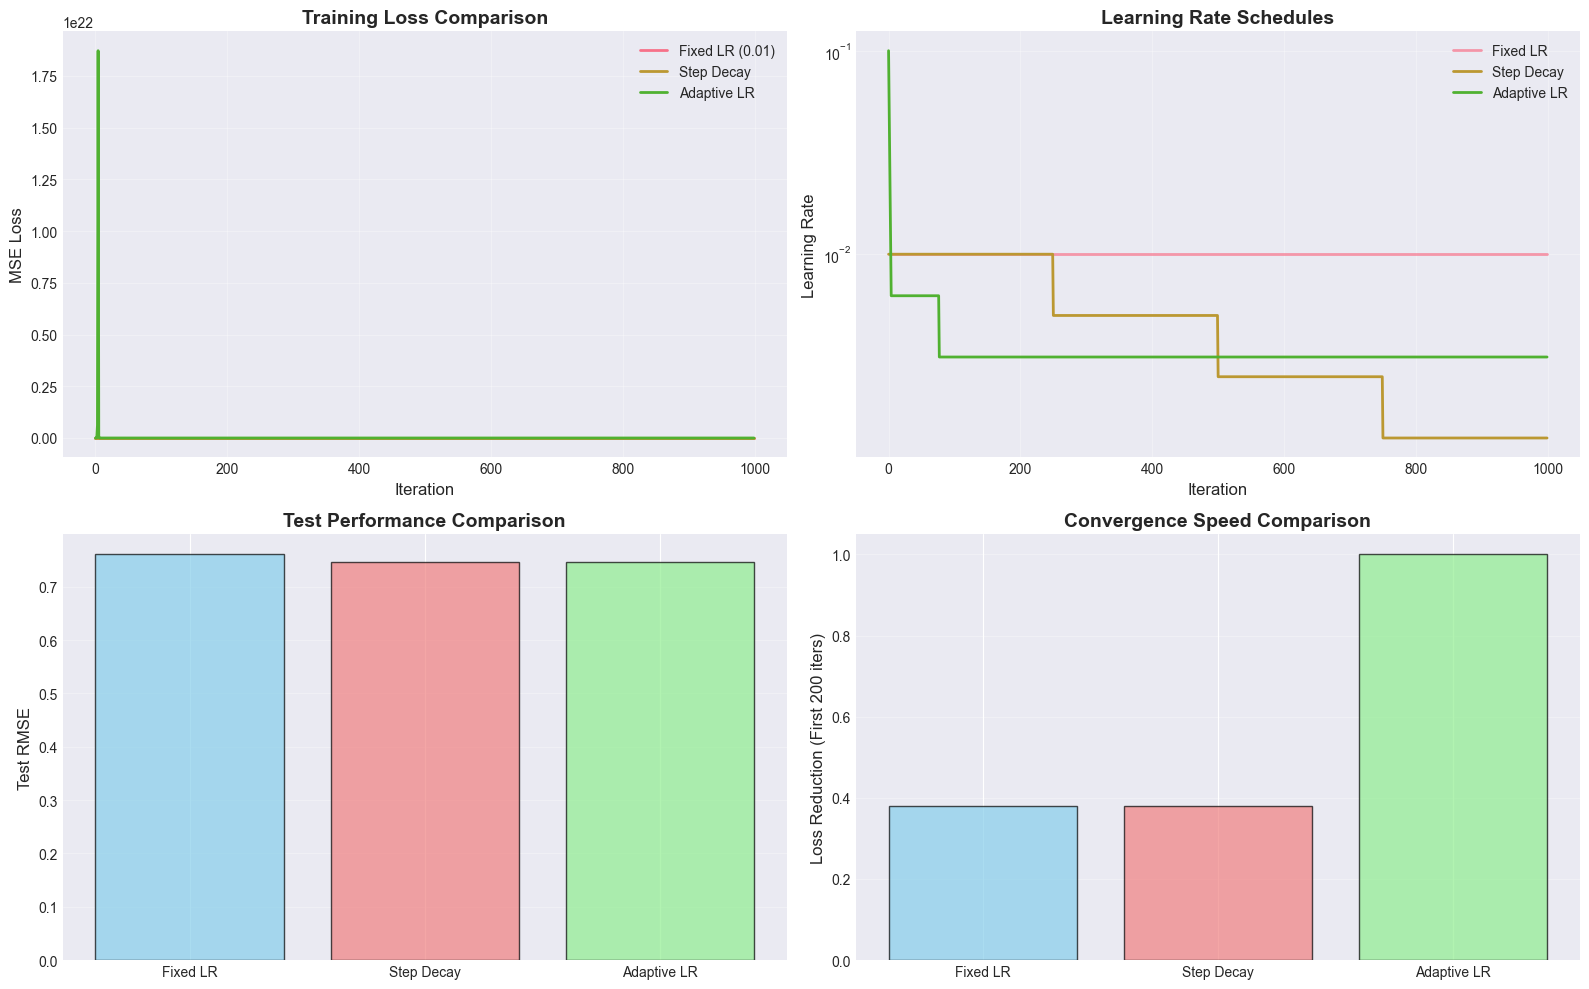


=== Summary ===
Fixed LR Test RMSE: 0.7608
Step Decay Test RMSE: 0.7462
Adaptive LR Test RMSE: 0.7466

Final Learning Rates:
Fixed LR: 0.01
Step Decay: 0.001250
Adaptive LR: 0.003125


In [8]:
plt.figure(figsize=(16, 10))

# Loss comparison
plt.subplot(2, 2, 1)
plt.plot(model_fixed.loss_history, label='Fixed LR (0.01)', linewidth=2)
plt.plot(model_step.loss_history, label='Step Decay', linewidth=2)
plt.plot(model_adaptive.loss_history, label='Adaptive LR', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate comparison
plt.subplot(2, 2, 2)
fixed_lr_hist = [0.01] * len(model_fixed.loss_history)
plt.plot(fixed_lr_hist, label='Fixed LR', linewidth=2, alpha=0.7)
plt.plot(model_step.lr_history, label='Step Decay', linewidth=2)
plt.plot(model_adaptive.lr_history, label='Adaptive LR', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.title('Learning Rate Schedules', fontsize=14, fontweight='bold')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Test performance comparison
plt.subplot(2, 2, 3)
methods = ['Fixed LR', 'Step Decay', 'Adaptive LR']
rmses = [test_rmse_fixed, test_rmse_step, test_rmse_adaptive]
plt.bar(methods, rmses, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
plt.ylabel('Test RMSE', fontsize=12)
plt.title('Test Performance Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Convergence speed (loss reduction over first 200 iterations)
plt.subplot(2, 2, 4)
window = 200
fixed_reduction = (model_fixed.loss_history[0] - model_fixed.loss_history[window-1]) / model_fixed.loss_history[0]
step_reduction = (model_step.loss_history[0] - model_step.loss_history[window-1]) / model_step.loss_history[0]
adaptive_reduction = (model_adaptive.loss_history[0] - model_adaptive.loss_history[window-1]) / model_adaptive.loss_history[0]

reductions = [fixed_reduction, step_reduction, adaptive_reduction]
plt.bar(methods, reductions, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
plt.ylabel('Loss Reduction (First 200 iters)', fontsize=12)
plt.title('Convergence Speed Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print(f"Fixed LR Test RMSE: {test_rmse_fixed:.4f}")
print(f"Step Decay Test RMSE: {test_rmse_step:.4f}")
print(f"Adaptive LR Test RMSE: {test_rmse_adaptive:.4f}")
print(f"\nFinal Learning Rates:")
print(f"Fixed LR: 0.01")
print(f"Step Decay: {model_step.lr_history[-1]:.6f}")
print(f"Adaptive LR: {model_adaptive.lr_history[-1]:.6f}")

## Analysis and Conclusions

### Key Observations:

1. **Adaptive Learning Rate**: Automatically responds to loss spikes, potentially improving stability
2. **Convergence Speed**: Adaptive LR may converge faster by starting high and reducing when needed
3. **Stability**: Dynamic adjustment helps avoid oscillations and divergence

### Research Insights:

- Adaptive learning rates offer a middle ground between fixed and scheduled approaches
- The spike detection mechanism provides automatic regularization
- Further tuning of spike thresholds and decay methods could optimize performance